In [ ]:
pip install transformers torch torchvision


Note: you may need to restart the kernel to use updated packages.


Using device: cuda


config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/179M [00:00<?, ?B/s]

Some weights of SegformerForImageClassification were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([1000, 512]) in the checkpoint and torch.Size([3, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10:
Train Loss: 0.6231, Train Accuracy: 0.6853
Val Loss: 0.3447, Val Accuracy: 0.8333
Epoch 2/10:
Train Loss: 0.3265, Train Accuracy: 0.8607
Val Loss: 0.1939, Val Accuracy: 0.9306
Epoch 3/10:
Train Loss: 0.1958, Train Accuracy: 0.9227
Val Loss: 0.1020, Val Accuracy: 0.9583
Epoch 4/10:
Train Loss: 0.1052, Train Accuracy: 0.9592
Val Loss: 0.0474, Val Accuracy: 0.9826
Epoch 5/10:
Train Loss: 0.0989, Train Accuracy: 0.9601
Val Loss: 0.0424, Val Accuracy: 0.9931
Epoch 6/10:
Train Loss: 0.0842, Train Accuracy: 0.9696
Val Loss: 0.1083, Val Accuracy: 0.9583
Epoch 7/10:
Train Loss: 0.0628, Train Accuracy: 0.9774
Val Loss: 0.0698, Val Accuracy: 0.9826
Epoch 8/10:
Train Loss: 0.0279, Train Accuracy: 0.9905
Val Loss: 0.0556, Val Accuracy: 0.9826
Epoch 9/10:
Train Loss: 0.0188, Train Accuracy: 0.9926
Val Loss: 0.0515, Val Accuracy: 0.9861
Epoch 10/10:
Train Loss: 0.0435, Train Accuracy: 0.9848
Val Loss: 0.0196, Val Accuracy: 0.9896

✅ Training complete.


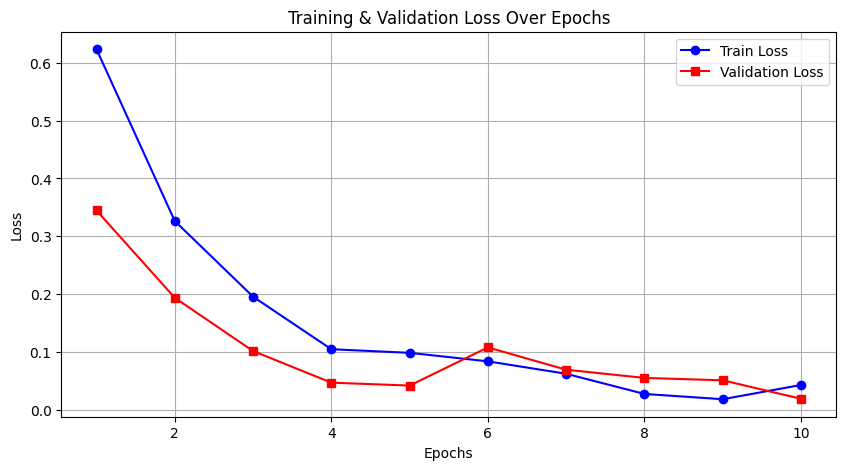


🧪 Evaluating on Test Set...

📊 **Test Set Performance Metrics**
✅ Test Accuracy: 0.9861
✅ Test Precision: 0.9863
✅ Test Recall: 0.9861
✅ Test F1 Score: 0.9861
✅ Test ROC AUC Score: 0.9995

📌 **Class-wise Test Accuracy**
✅ benign: 98.96%
✅ malignant: 97.92%
✅ normal: 98.96%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from transformers import SegformerForImageClassification
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 🚀 Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 📂 Dataset path
data_dir = "/kaggle/input/lung-cancer-dataset1"

# ✅ Standard Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 📂 Load datasets
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "train"), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, "test"), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

# 🚀 Load SegFormer (Pretrained)
model = SegformerForImageClassification.from_pretrained(
    "nvidia/mit-b3", num_labels=len(train_dataset.classes), ignore_mismatched_sizes=True
)
model = model.to(device)

# 🔥 Weighted Loss to fix class imbalance
class_counts = np.bincount([label for _, label in train_dataset.samples])
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# 🏋️ Training settings
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds, train_labels = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_acc = accuracy_score(train_labels, train_preds)
    train_accuracies.append(train_acc)

    # 🚀 Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    val_probs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_probs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            val_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    val_acc = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_acc:.4f}")

    scheduler.step(val_loss)

print("\n✅ Training complete.")

# 📈 Plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", color='blue', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", color='red', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# 🧪 Final Evaluation on Test Set
print("\n🧪 Evaluating on Test Set...")
model.eval()
test_preds, test_labels, test_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        probs = torch.nn.functional.softmax(outputs, dim=1)

        test_preds.extend(outputs.argmax(dim=1).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())
        test_probs.extend(probs.cpu().numpy())

# 📊 Compute Test Metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
test_recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)
test_auc = roc_auc_score(test_labels, test_probs, multi_class='ovr')

print("\n📊 **Test Set Performance Metrics**")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Precision: {test_precision:.4f}")
print(f"✅ Test Recall: {test_recall:.4f}")
print(f"✅ Test F1 Score: {test_f1:.4f}")
print(f"✅ Test ROC AUC Score: {test_auc:.4f}")

# 📌 Class-wise Accuracy on Test Set
test_class_correct = {class_name: 0 for class_name in test_dataset.classes}
test_class_total = {class_name: 0 for class_name in test_dataset.classes}

for label, pred in zip(test_labels, test_preds):
    test_class_total[test_dataset.classes[label]] += 1
    if label == pred:
        test_class_correct[test_dataset.classes[label]] += 1

print("\n📌 **Class-wise Test Accuracy**")
for class_name in test_dataset.classes:
    accuracy = test_class_correct[class_name] / test_class_total[class_name] * 100
    print(f"✅ {class_name}: {accuracy:.2f}%")


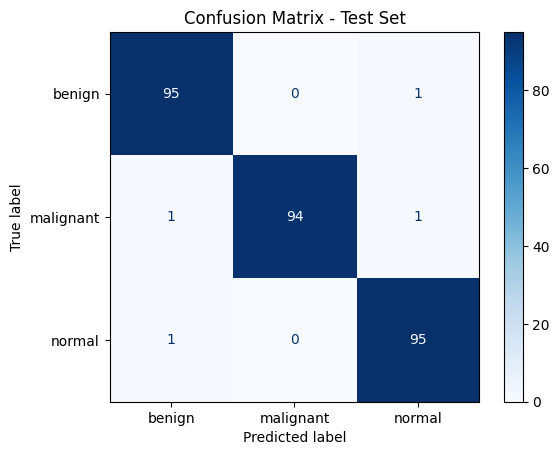

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create the confusion matrix
cm = confusion_matrix(test_labels, test_preds)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_dataset.classes)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix - Test Set")
plt.grid(False)
plt.show()


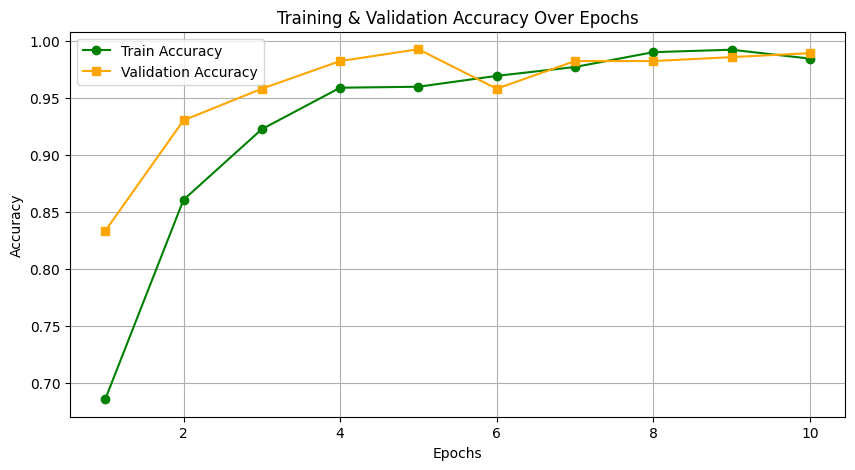

In [ ]:
# 📈 Plot Accuracy Curves
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", color='green', marker='o')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color='orange', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


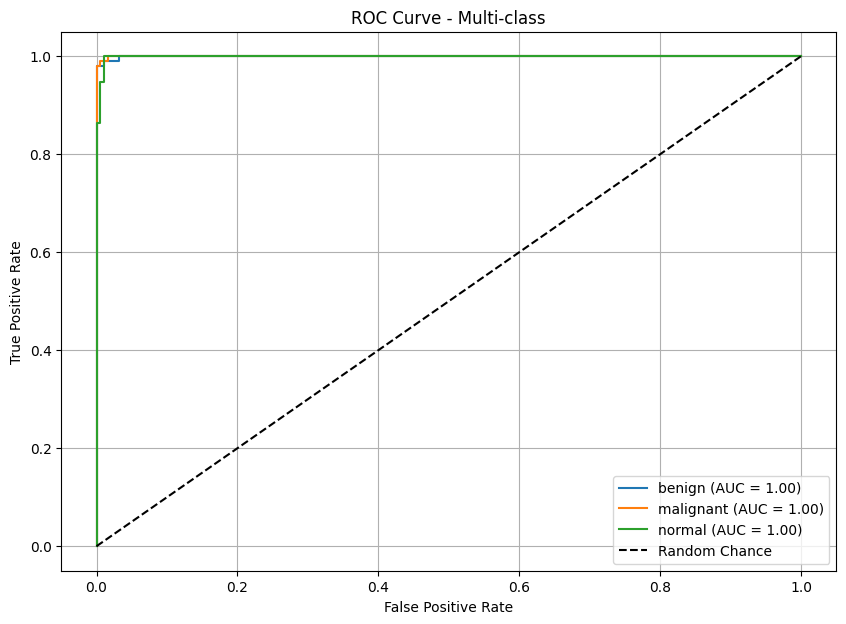

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the labels for multi-class ROC
n_classes = len(test_dataset.classes)
y_true_bin = label_binarize(test_labels, classes=range(n_classes))
y_score = np.array(test_probs)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 7))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{test_dataset.classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
